# Top-down sampling and direct optimization 


In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import hsv_to_rgb
import copy
import heapq
import time


##  Deep-Sea Environment

In [29]:
RIGHT = 0
LEFT = 1

ACTIONS = ['RIGHT', 'LEFT']
num_actions = len(ACTIONS)

In [30]:
left_wind = 0.0
mean_reward = 0.0
std_reward = 0
env_eps = 1.0/3.0 
goal = 1.0

In [31]:
class DeepSea:
    terrain_color = dict(normal=[127.0/360, 0.0, 96.0/100],                         
                         objective=[220.0/360, 90.0/100, 100.0/100],                         
                         player=[344.0/360, 93.0/100, 100.0/100])        
    def __init__(self,L,mean = 0, std =1, goal=1, p=0.1,eps=0.1,plot_init=False):
        self.height = L 
        self.width = L 
        self.start = (0,0)
        self.obj = (self.height-1,self.width-1)
        self.num_states = self.width * self.height
        
        self.mean_reward, self.std_reward = mean,std
        self.goal_bonus = goal
        self.p = p
        assert (eps >= 0), 'epsilon must be <=0'
        self.eps = eps
        
        self.player = None
        self._create_grid()
        if plot_init:
            self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((self.height, self.width, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid,history = None):       

        grid[self.obj] = self.terrain_color['objective']
        grid[self.start] = self.terrain_color['player']
        if history is not None:
            for idx in history:
                grid[self._id_to_position(idx)] = self.terrain_color['player']
    def _draw_grid(self,s=0):
        self.fig, self.ax = plt.subplots(figsize=(self.width+s, self.height+s))
        self.ax.grid(which='minor')
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], s='0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(self.height * self.width)]  
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1) 
        
        self.ax.set_xticks(np.arange(self.width))
        self.ax.set_xticks(np.arange(self.width) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(self.height))
        self.ax.set_yticks(np.arange(self.height) - 0.5, minor=True)
        
    def reset(self):
        self.player = self.start      
        return self._position_to_id(self.player)
    
    def step(self,state, action):
        # Possible actions
        base_reward = 0
        state = self._id_to_position(state)
        state = (state[0]+1, state[1])
        self.success =False
        p_ = np.random.rand()
        if action == RIGHT and p_ < (1-self.p):            
            state = (state[0], state[1] + 1)
            
        elif state[1] > 0  : 
            state = (state[0], state[1] - 1)
            
        if action == LEFT:
            reward = np.random.normal(self.mean_reward,self.std_reward)
        else:
            reward = np.random.normal(self.mean_reward-self.eps,self.std_reward)

        if all(self.grid[state] == self.terrain_color['objective']):
            reward = np.random.normal(self.mean_reward+self.goal_bonus,10.0+self.std_reward)
            self.success =True
            done = True

        elif state[0] == self.height-1:
            done = True
        else:
            done =False
            
        return self._position_to_id(state), reward, done

            
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * self.width + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // self.width), (idx % self.width)
        
    def render(self, q_values=None,stds=None, action=None,history = None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        def change_range(values, vmin=0, vmax=1):
            start_zero = values - np.min(values)
            return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin 
                    
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((self.height, self.width, 3))

            values = q_values[:,0].reshape(self.height, self.width)
            grid[:, :, 1] = values+0.1


            qe = q_values.reshape(self.height, self.width,2)
            grid[np.where(qe.sum(2)==0)] -= 0.1
            grid = np.clip(grid,0,1)
            self._add_objectives(grid,history)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))

        if q_values is not None:
            xs = np.repeat(np.arange(self.width), self.height)
            ys = np.tile(np.arange(self.height), self.width)

            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                elif stds is None:                
                    actions = ['R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                else:                    
                    actions = ['R', 'L']
                    txt = '\n'.join(['{}:{:.2f} ± {:.3f}'.format(k, q,s) for k, q,s in zip(actions,q_values[i],stds[i])])
                    text.set_text(txt)


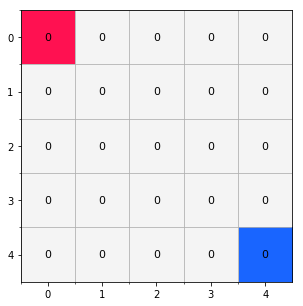

In [32]:
env = DeepSea(L=5, mean=mean_reward, std=std_reward, goal=goal, p=left_wind, eps=env_eps,plot_init=True)
num_states = env.width * env.height
max_steps = env.height

## Policy model

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import collections


In [34]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.fc = nn.Linear(num_states,num_actions)        
        
    def forward(self,state):
        # convert idx of state to 'one-hot'
        state = torch.FloatTensor(state.size(0),num_states).zero_().scatter_(-1, state,1.0)        
        logits = self.fc(state)        
        return F.log_softmax(logits,dim=-1)         

policy = Policy()


## Top-down construction 

In [35]:
def sample_gumbel(mu):
    """Sample a Gumbel(mu)."""    
    return -np.log(np.random.exponential()) + mu


def sample_truncated_gumbel(mu, b):
    """Sample a Gumbel(mu) truncated to be less than b."""    
    return -np.log(np.random.exponential() + np.exp(-b + mu)) + mu

  
def sample_gumbel_argmax(logits):
    """Sample from a softmax distribution over logits.

    TODO: check this is correct.

    Args:
    logits: A flat numpy array of logits.

    Returns:
    A sample from softmax(logits).
    """
    return np.argmax(-np.log(np.random.exponential(size=logits.shape)) + logits)


def logsumexp(logits):
    c = np.max(logits)
    return np.log(np.sum(np.exp(logits - c))) + c


def log_softmax(logits, axis=1):
    """Normalize logits per row so that they are logprobs.
  
      TODO: check this is correct. 
    """
    maxes = np.max(logits, axis=axis, keepdims=True)
    offset_logits = logits - maxes
    log_zs = np.log(np.sum(np.exp(offset_logits), axis=axis, keepdims=True))
    return offset_logits - log_zs

In [36]:
# Make a node without a state, and also don't allow `next_actions` to be None.
# Just put in all possible next actions when the node is created.

# Namedtuple for storing results
Trajectory = collections.namedtuple('Trajectory', ['actions','states','gumbel','reward','status','node'])

class Node:
    epsilon = 1.0
    discount = 1.0
    def __init__(self,                 
                 states,
                 prefix=[],                 
                 reward_so_far=0,
                 done=False,
                 logprob_so_far=0,
                 max_gumbel=sample_gumbel(0),
                 next_actions=range(num_actions),
                 t_opt=True):
        
  
        self.prefix = prefix
        self.states = states
        self.reward_so_far = reward_so_far
        self.done = done
        self.logprob_so_far = logprob_so_far
        self.max_gumbel = max_gumbel
        self.next_actions = next_actions
        
        self.t_opt = t_opt
        self.priority = self.max_gumbel + self.epsilon*self.reward_so_far #*self.discount**len(self.prefix)
        

    def __lt__(self, other):
        if self.t_opt == other.t_opt: #false==false
            return self.priority >  other.priority
        
        elif self.t_opt:
            """
            This is how we sample t_opt, the starting node is with t_opt=True and
            its 'special child' will be also with t_opt=True and because we always returning true
            when we compare it to the 'other childrens' (where t_opt=False) the special path is sampled (speical childs only) 
            """
            return True

In [37]:
def sample_t_opt_and_search_for_t_direct(policy_model,                                         
                                         num_actions,
                                         max_trajectory_length,
                                         max_search_time=float('Inf'),
                                         epsilon=1.0,
                                         inference=False):
    """Samples an independent Gumbel(logprob) for each trajectory in top-down-ish order.

    Args:
        policy_model: Pytorch model that gets state and returns actions logits
        environment: Initial environment that initialized with random seed
        num_actions: Number of possible actions, should be equal to the policy output size
        max_trajectory_length: Maximum length of a trajectory to allow.
        max_search_time: Maximum searching time of t_direct
        epsilon: direct optimization parameter
        inference: sampling t_opt without searching for t_direct
    Returns:
        y_opt: trajectory of max gumbel 
        y_direct: trajectory of max gumbel + reward*epsilon (target)
        final_trajectories: int, number of all trajectories (can be deleted, just for debugging)
    """
    to_print = False
    Node.epsilon = epsilon
    root_node = Node(        
        states = [env.reset()],
        max_gumbel=sample_gumbel(0))
    
    queue = []
    heapq.heappush(queue,root_node)
    max_gumbel_eps_reward ,max_gumbel= -float('Inf'),-float('Inf')
    final_trajectories = []
    
    start_time = time.time()
    while queue:
        if to_print:
            print(10*'-')
            for q in queue:                
                print(q.priority,q.t_opt,'|',q.prefix,q.reward_so_far,q.logprob_so_far,q.max_gumbel,q.next_actions)           
        
        parent = heapq.heappop(queue)
        if inference and not parent.t_opt:
            t_direct=None
            break 

        if  len(parent.prefix) == max_trajectory_length or parent.done:
            t = Trajectory(actions=parent.prefix,
                           states=parent.states,
                           gumbel=parent.max_gumbel,
                           reward=parent.reward_so_far,
                           status=parent.done,
                           node = parent)
            
            assert len(t.actions) == len(parent.states)-1
            final_trajectories.append(t)
            if parent.t_opt:
                t_opt = t
                
            else:    
                if parent.priority>max_gumbel_eps_reward:
                    max_gumbel_eps_reward = parent.priority
                    t_direct = t  
            continue
            
        if time.time()-start_time>max_search_time:
            if len(final_trajectories)==0:                
                t_direct = Trajectory(actions=parent.prefix,
                           states=parent.states,
                           gumbel=parent.max_gumbel,
                           reward=parent.reward_so_far,
                           status=parent.done,
                           node = parent)
                final_trajectories.append(t_direct)                
            break

        current_state = parent.states[-1]   
        with torch.no_grad():
            policy_model.eval()
            state = torch.LongTensor([current_state]).unsqueeze(0)
            action_logprobs = policy_model(state).numpy().squeeze(0)
        
        next_action_logprobs = action_logprobs[parent.next_actions]
        
        special_action_index = sample_gumbel_argmax(next_action_logprobs)
        
        special_action = parent.next_actions[special_action_index]
        special_action_logprob = action_logprobs[special_action]        

        new_state,reward,done = env.step(current_state,special_action)
        
        special_child = Node(                             
                             prefix=parent.prefix + [special_action],
                             states=parent.states + [new_state],
                             reward_so_far=parent.reward_so_far + reward,
                             done=done,
                             logprob_so_far=parent.logprob_so_far + special_action_logprob,
                             max_gumbel=parent.max_gumbel, 
                             next_actions=range(num_actions),# All next actions are possible.
                             t_opt = parent.t_opt) 

        
        heapq.heappush(queue,special_child)
        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        other_actions = [i for i in parent.next_actions if i != special_action]
        assert len(other_actions) == len(parent.next_actions) - 1

        if other_actions:
            
            other_max_location = logsumexp(action_logprobs[other_actions])
            other_max_gumbel = sample_truncated_gumbel(parent.logprob_so_far + other_max_location, 
                                                     parent.max_gumbel)
            
            other_children = Node(                                
                                prefix=parent.prefix,
                                states=parent.states,
                                reward_so_far=parent.reward_so_far,
                                done=parent.done,
                                logprob_so_far=parent.logprob_so_far,
                                max_gumbel=other_max_gumbel,
                                next_actions=other_actions,
                                t_opt = False) 
        
            heapq.heappush(queue,other_children)

    return t_opt, t_direct,final_trajectories


In [38]:

# example
t_opt, t_direct,final_trajectories = sample_t_opt_and_search_for_t_direct(policy,num_actions,max_steps)
print ('t_direct actions \n',t_direct.actions)
print ('t_opt actions \n',t_opt.actions)
print("Expected {} vs actual {}".format(num_actions**(max_steps-1),
                                        len(final_trajectories)))

t_direct actions 
 [0, 0, 0, 0]
t_opt actions 
 [0, 0, 1, 1]
Expected 16 vs actual 15


## Direct optimization 

In [39]:
def direct_optimization_loss(policy_model,t_opt,t_direct,epsilon=1.0):
    """computes \nabla \phi(a,s) = \sum_{t=1}^T \nabla \phi(a_t, s_t) with direct optimization
    
    Args:
        policy_model: Pytorch model gets state and returns actions logits 
        t_opt: trajectory with the max(gumbel)
        t_direct: trajectory with the max(gumbel+epsilon*reward) 
        epsilon: for direct optimization, usually between 0.9-1.0
    Returns: 
        logits multiplied with vector of (1,0,..,-1) [for example]
        so when we derive it with backward we ends up with \nabla \phi_opt(a,s) - \nabla \phi_direct(a,s)"""
    direct_states  = t_direct.states
    direct_states = torch.LongTensor(direct_states)[:-1].view(-1,1)
    opt_states  = t_opt.states
    opt_states = torch.LongTensor(opt_states)[:-1].view(-1,1)
    
    direct_actions = t_direct.actions
    direct_actions = torch.LongTensor(direct_actions).view(-1,1)
    opt_actions = t_opt.actions    
    opt_actions = torch.LongTensor(opt_actions).view(-1,1)
    
    opt_direct_states = torch.cat((opt_states,direct_states))
    
    phi = policy_model(opt_direct_states) # gets the logits so the network will calculates weights gradients

    #print phi
    y_direct = - torch.FloatTensor(direct_actions.size(0),phi.size(1)).zero_().scatter_(-1,direct_actions,1.0) # one-hot that points to the best direction
    y_opt = torch.FloatTensor(opt_actions.size(0),phi.size(1)).zero_().scatter_(-1, opt_actions,1.0)
    
    y_opt_direct = torch.cat((y_opt,y_direct))
    y_opt_direct = y_opt_direct*(1.0/epsilon)

    policy_loss = torch.sum(y_opt_direct*phi)   
    return policy_loss

## Training 

In [40]:
def get_k_direct_k_star(traj_list,t_direct):
    """
    - Sort trajectories by t_opt (phi+gumbel) and compute how far down t_direct and t* (trajectory with maximum reward) fall on the list.
    Returning these positions k_direct and k*.
    """
    sorted_traj = sorted(traj_list, key=lambda t: t.gumbel)
    t_star = max(traj_list, key=lambda t: t.reward)
    k_direct = sorted_traj.index(t_direct)
    k_star = sorted_traj.index(t_star)
    
    return [(k_direct,k_star),(sorted_traj[k_direct].gumbel,sorted_traj[k_star].gumbel)]



In [41]:

def run_episode(actions_list):
    """Interacts with the environment given actions """
    rewards = 0
    done = False
    success = False
    state = env.reset()
    for action in actions_list: 
        state, reward, done = env.step(state,action)
        if env.success:
            success = True
        rewards += reward
    return rewards,success

In [42]:
def train_policy_model(policy_model, num_episodes=500,epsilon=1.0,visualize=False):

    optimizer = optim.Adam(policy_model.parameters(), lr=0.001)
    success = 0
    rewards = []
    k_direct_star = []
    for episode in range(num_episodes):
        t_opt, t_direct,final_trajectories = sample_t_opt_and_search_for_t_direct(policy_model=policy_model,
                                                                                  num_actions=num_actions,
                                                                                  max_trajectory_length=max_steps,
                                                                                  epsilon=epsilon)
        if episode%60 == 0 and visualize:
            k_direct_star.append(get_k_direct_k_star(final_trajectories,t_direct))
        if t_direct.node.priority > t_opt.node.priority: 
            policy_loss = direct_optimization_loss(policy_model = policy_model,
                                                   t_opt=t_opt,
                                                   t_direct=t_direct,
                                                   epsilon=epsilon)

            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()
        
        trajectory_reward,suc = run_episode(t_opt.actions)
        
        success += suc
        rewards.append(trajectory_reward)
    return policy_model,success,rewards,k_direct_star

def test(policy_model, num_episodes=500,epsilon=1.0):

    success = 0
    rewards = []
    for episode in range(num_episodes):
        t_opt, t_direct,final_trajectories = sample_t_opt_and_search_for_t_direct(policy_model=policy_model,
                                                                                  num_actions=num_actions,
                                                                                  max_trajectory_length=max_steps,
                                                                                  epsilon=epsilon,
                                                                                  inference=True)

        
        trajectory_reward,suc = run_episode(t_opt.actions)
        success += suc
        rewards.append(trajectory_reward) 
    return success,rewards


## Visualization

In [43]:
splots = 0
def visualize_k_direct_k_star(k_direct_star_list):
    global splots
    k_tuples,gumbel_tuples = zip(*k_direct_star_list)
    k_direct_list,k_star_list = zip(*k_tuples)
    gumbel_direct_list,gumbel_star_list = zip(*gumbel_tuples)
    
    ax = fig.add_subplot(4,4,splots)
    ax.plot(k_direct_list,'ro',markersize=4)
    ax.plot(k_star_list,'bo',markersize=2)
    ax.title.set_text('epsilon = '+str(eps) +' \n K location')
    splots += 1
    ax = fig.add_subplot(4,4,splots)
    ax.plot(gumbel_direct_list,'ro',markersize=4)
    ax.plot(gumbel_star_list,'bo',markersize=2)
    ax.title.set_text('epsilon = '+str(eps) +' \n Gumbel value')    


epsilons = np.around(np.concatenate((-2**(np.linspace(5,0.01,10)-3),2**(np.linspace(0.01,5,10)-3))),decimals=2)

visualize = False
meta_policies=[]
seed = 66
trials=4
for trial in range(trials):
    policies=[]
    for eps in epsilons:
        np.random.seed(seed)
        policy = Policy()
        policy,num_success,rewards,k_direct_star = train_policy_model(policy,num_episodes=400000,epsilon=eps,visualize=visualize)
        num_success,rewards = test(policy,num_episodes=2000,epsilon=eps)
        if trial==trials-1 and visualize:
            splots += 1
            visualize_k_direct_k_star(k_direct_star)
        suc_ratio = float(num_success)/2000
        policies.append((eps,suc_ratio,policy))
    seed+=1
    meta_policies.append(policies)

if visualize:    
    fig.legend(['k_direct','k_star'],loc='center left', bbox_to_anchor=(1, 0.5))
    fig.text(0.5, 0, 'Training iterations', ha='center',fontsize=16)
    fig.text(0, 0.5, 'Index in sorted phi+gumbel', va='center', rotation='vertical',fontsize=16)
    fig.tight_layout()
    fig.show()



In [44]:
def fill_q_values(policy,traj=[0,0,0,0]):
    q_values_pg = np.zeros((env.width * env.height, num_actions,1))
    n = 3000
    count_l=0
    count_r=0
    for i in range(n):
        t_opt,t_direct,_ = sample_t_opt_and_search_for_t_direct(policy,num_actions,max_steps,inference = True)
        actions = t_opt.actions
        states = t_opt.states
        for j,s in enumerate(states):
            if j==len(states)-1:
                break

            q_values_pg[s,actions[j]]+=1
            
        if actions==[RIGHT,RIGHT,RIGHT,RIGHT]:
            count_r+=1.0
        elif actions==[LEFT,LEFT,LEFT,LEFT]:
            count_l+=1.0
        
    prob_r = count_r/n
    prob_l = count_l/n
    a=q_values_pg.squeeze(2)/n 
    where_are_NaNs = np.isnan(a)
    a[where_are_NaNs] = 0

    return a,(prob_r,prob_l)

In [45]:
def play(policy=None,mean_qv=None,stds=None):
    env = DeepSea(L=5, mean=mean_reward, std=std_reward, goal=goal, p=left_wind, eps=env_eps)
    
    state = env.reset()
    s=0
    if stds is not None:
        s=3
    env._draw_grid(s)
    done = False
    history = [state]
    
    if policy is not None:
        t_opt,t_direct,_ = sample_t_opt_and_search_for_t_direct(policy,num_actions,max_steps,inference=True)
        actions = t_opt.actions
        print ([ACTIONS[actions[i]] for i in range(len(actions))])
    elif mean_qv is not None:
        history=None
        env.render(q_values=mean_qv,stds=stds ,history=history, colorize_q=True)        
        return
    else:
        print('policy or mean_qv must be not None')

    for action in actions:
        state, reward, done = env.step(state,action)
        env.player = env._id_to_position(state)         
        history.append(state)
        env.render(q_values=fill_q_values(policy)[0] ,history=history, colorize_q=True)
        if done:
            return



In [46]:
qv=[]
probs=[]
for p in zip(*meta_policies):
    eps,suc_ratio,policy = zip(*p)

    print ('epsilon: {}, mean success rate: {:.4f},std: {:.4f}'.format(eps[0],
                                                                       np.mean(suc_ratio),
                                                                       np.std(suc_ratio)))
    
    state_prob,traj_prob = zip(*map(fill_q_values,policy))
    probs.append(traj_prob)
    qv.append(np.array(state_prob))
qv = np.array(qv)
probs = np.array(probs)
print (qv.shape)
print (probs.shape)
means_qv= qv.mean(1)
std_qv = qv.std(1)

means_probs= probs.mean(1)
std_probs = probs.std(1)


epsilon: -4.0, mean success rate: 0.0000,std: 0.0000
epsilon: -2.72, mean success rate: 0.0000,std: 0.0000
epsilon: -1.85, mean success rate: 0.0000,std: 0.0000
epsilon: -1.26, mean success rate: 0.0000,std: 0.0000
epsilon: -0.86, mean success rate: 0.0000,std: 0.0000
epsilon: -0.59, mean success rate: 0.0000,std: 0.0000
epsilon: -0.4, mean success rate: 0.0000,std: 0.0000
epsilon: -0.27, mean success rate: 0.0000,std: 0.0000
epsilon: -0.18, mean success rate: 0.0000,std: 0.0000
epsilon: -0.13, mean success rate: 0.0000,std: 0.0000
epsilon: 0.13, mean success rate: 0.5090,std: 0.0193
epsilon: 0.18, mean success rate: 0.5047,std: 0.0100
epsilon: 0.27, mean success rate: 0.5021,std: 0.0120
epsilon: 0.4, mean success rate: 0.4981,std: 0.0171
epsilon: 0.59, mean success rate: 0.4960,std: 0.0140
epsilon: 0.86, mean success rate: 0.5078,std: 0.0191
epsilon: 1.26, mean success rate: 0.4850,std: 0.0208
epsilon: 1.85, mean success rate: 0.4864,std: 0.0150
epsilon: 2.72, mean success rate: 0.483

epsilon=-4.0, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-2.72, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-1.85, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-1.26, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.86, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.59, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.4, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.27, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.18, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=-0.13, success ratio: 0.0000 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=0.13, success ratio: 0.4785 
['RIGHT', 'RIGHT', 'RIGHT', 'RIGHT']
epsilon=0.18, success ratio: 0.5035 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=0.27, success ratio: 0.4980 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=0.4, success ratio: 0.5145 
['LEFT', 'LEFT', 'LEFT', 'LEFT']
epsilon=0

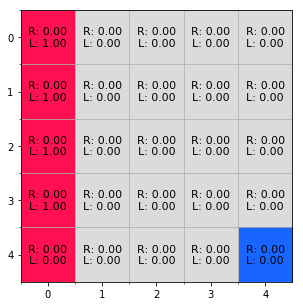

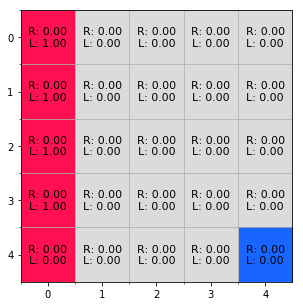

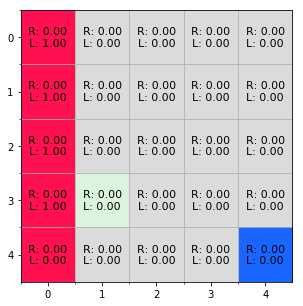

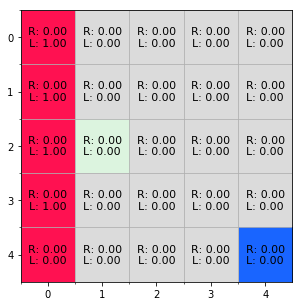

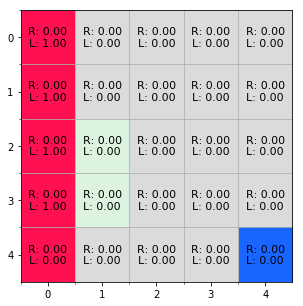

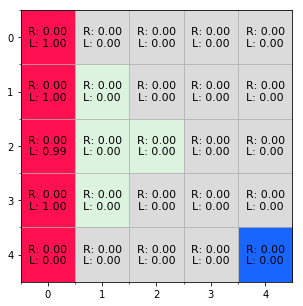

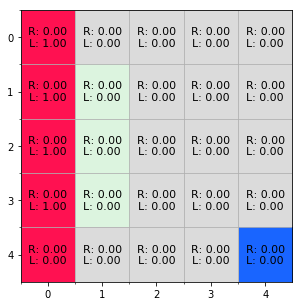

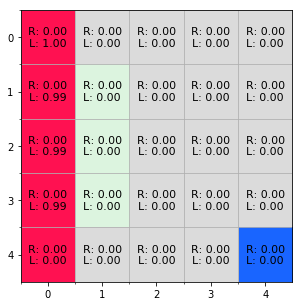

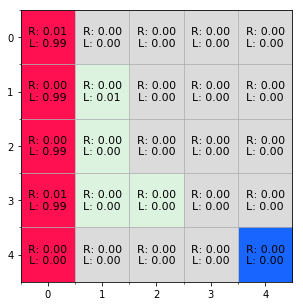

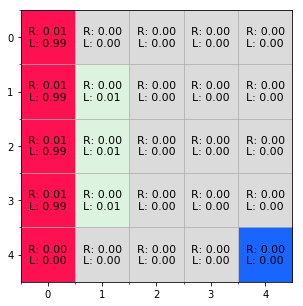

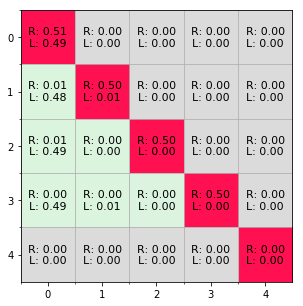

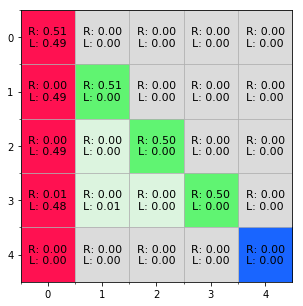

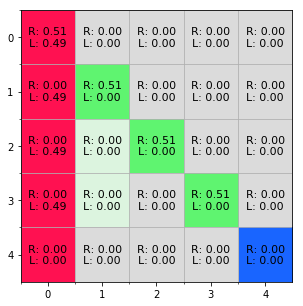

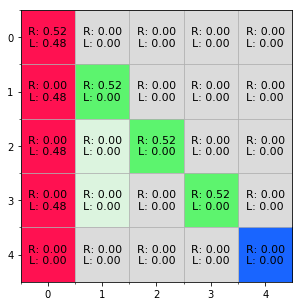

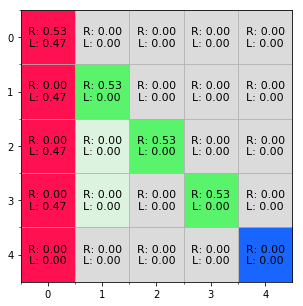

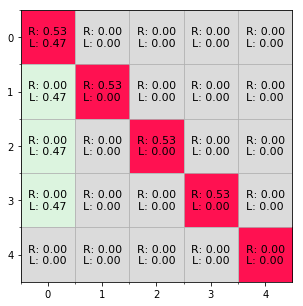

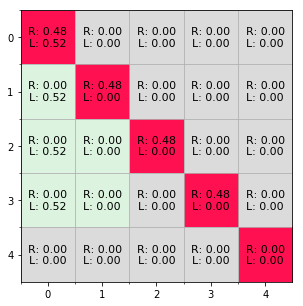

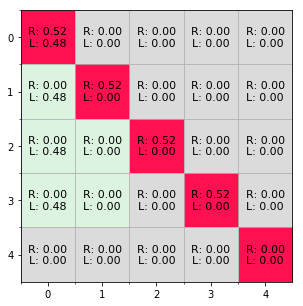

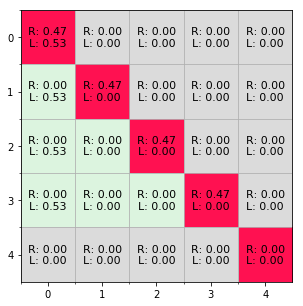

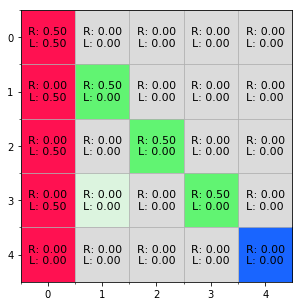

In [47]:
# A realization of one seed game
for p in meta_policies[1]:
    print ("epsilon={}, success ratio: {:.4f} ".format(p[0],p[1]) )
    play(p[-1])

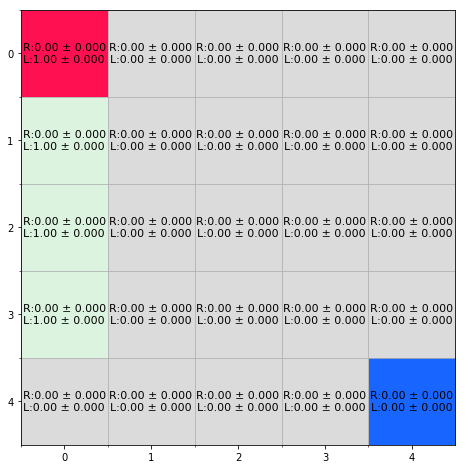

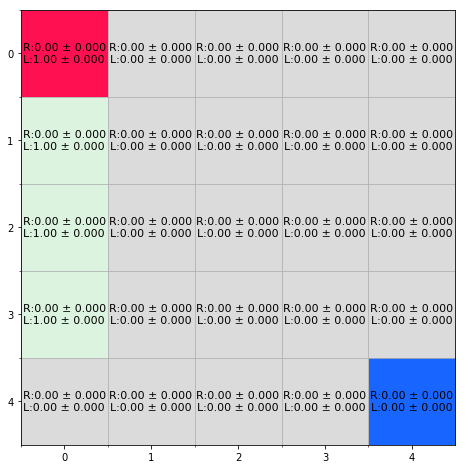

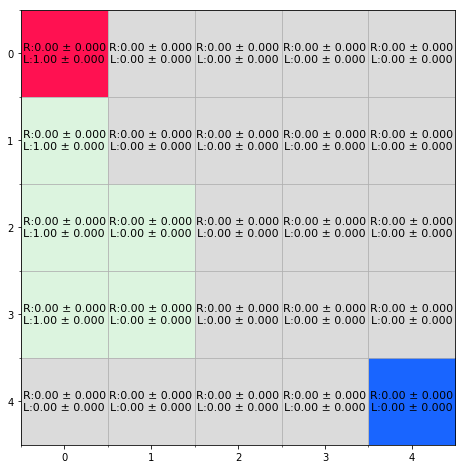

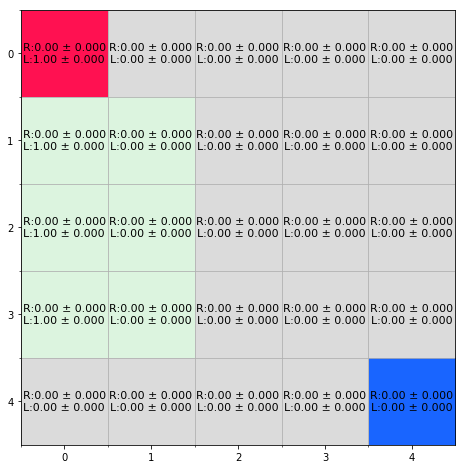

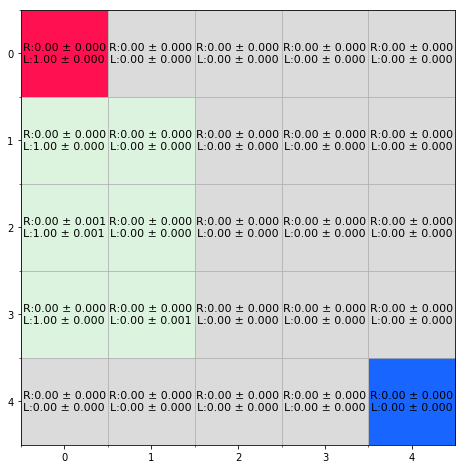

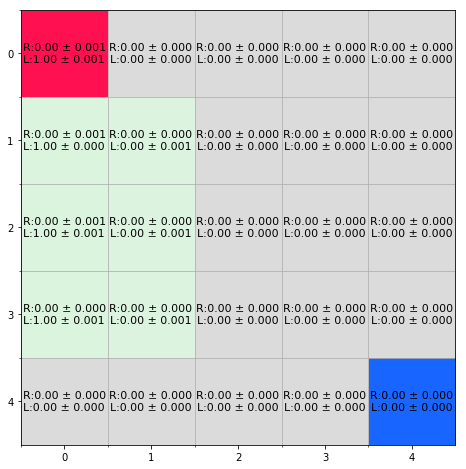

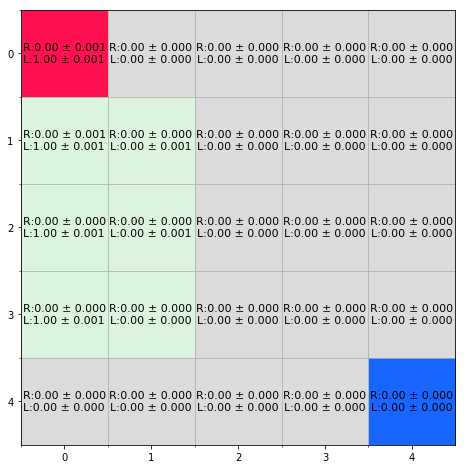

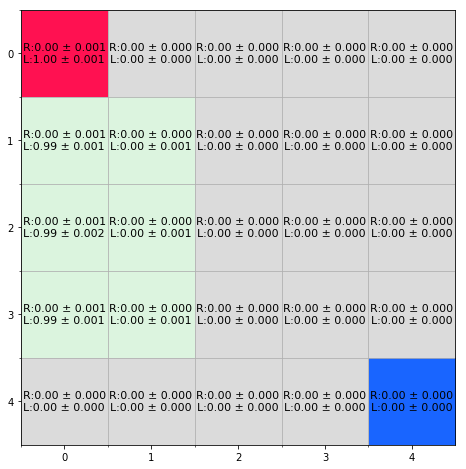

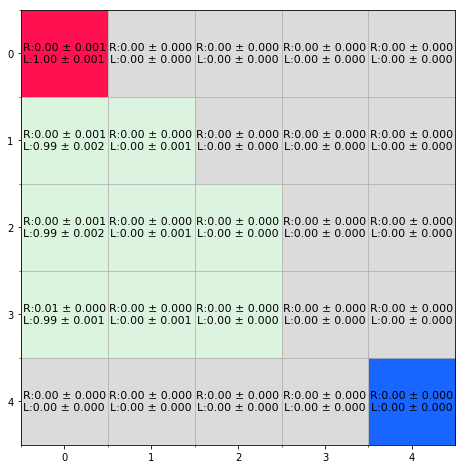

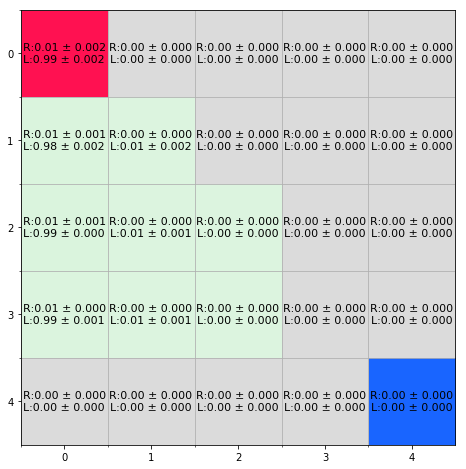

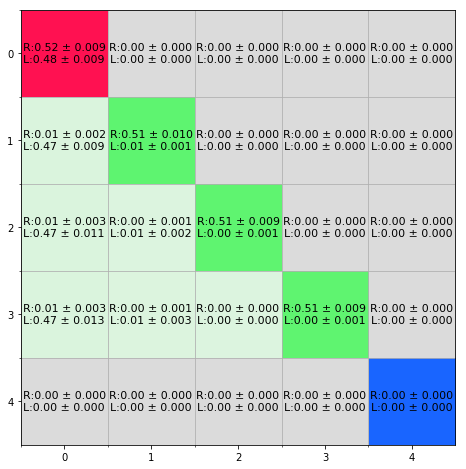

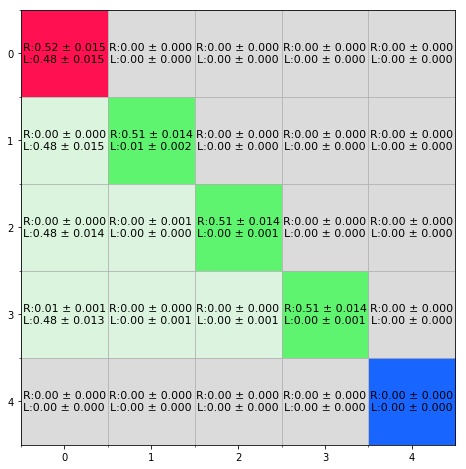

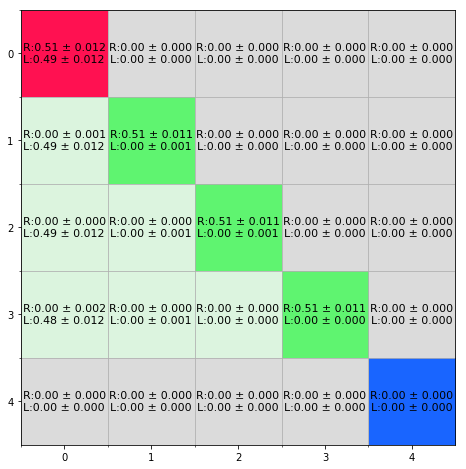

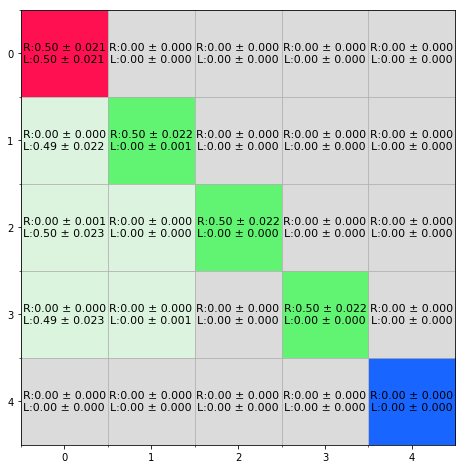

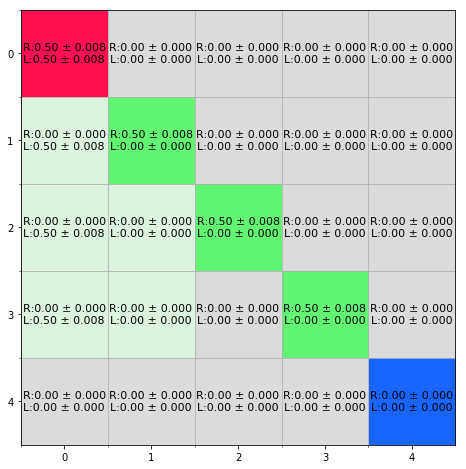

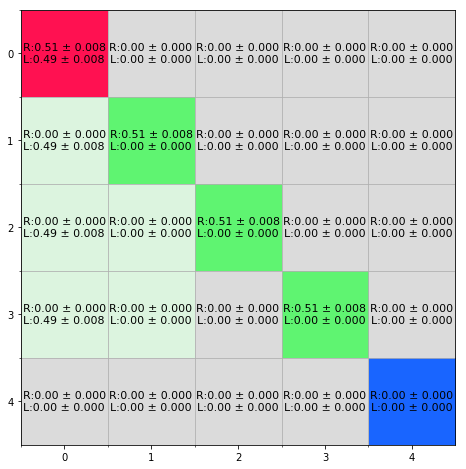

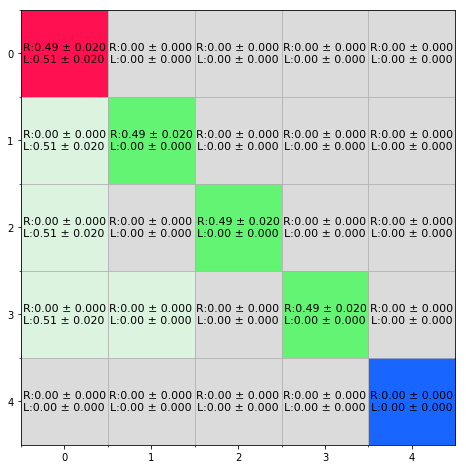

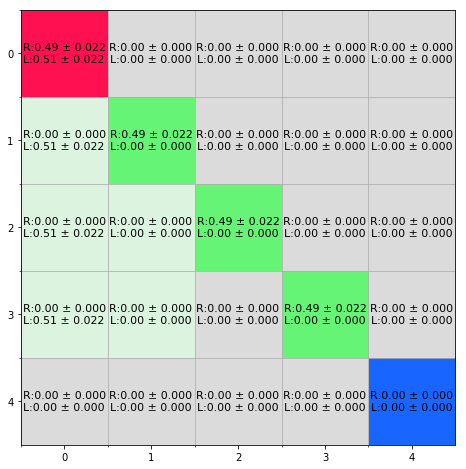

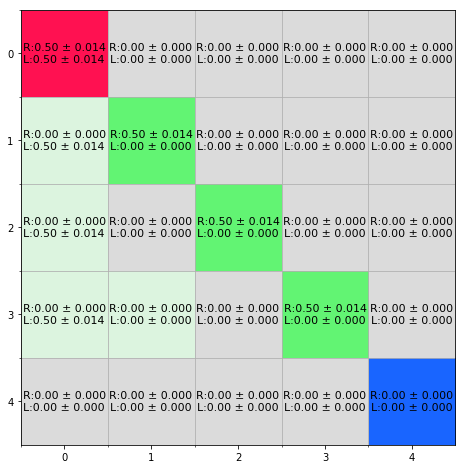

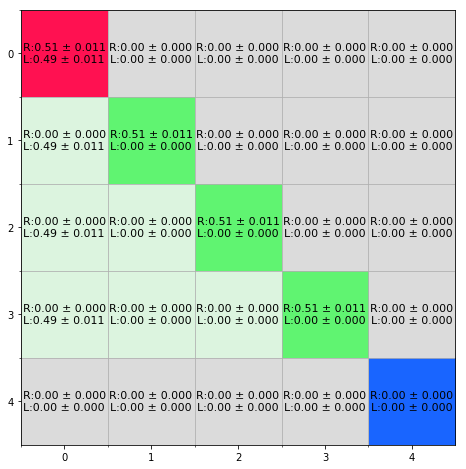

In [48]:
# Visualization of the learnt action probs: mean across all seeds

for mqv,stds in zip(means_qv,std_qv):
    play(mean_qv=mqv,stds=stds)

In [113]:
def plot_probability_of_trajctory(traj1,traj2,title='',filename='new_plot.png'):
    plt.figure(figsize=(10,8))
    x1,y1,err1,label1 = traj1
    x2,y2,err2,label2 = traj2
    plt.xscale('symlog',basex=2)
    plt.errorbar(x1,y1,yerr=err1,label=label1,fmt='o',markersize=11,elinewidth=3)
    plt.errorbar(x2,y2,yerr=err2,label=label2,fmt='o',markersize=11,elinewidth=3)

    plt.axhline(y=0.5, color='k', linestyle='--', alpha=.3)
    plt.legend(fontsize=24)

    plt.title(title)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel('epsilon',fontsize=24)
    plt.ylabel('probability',fontsize=24)
    plt.savefig(filename)
    plt.show()
    plt.clf()
    


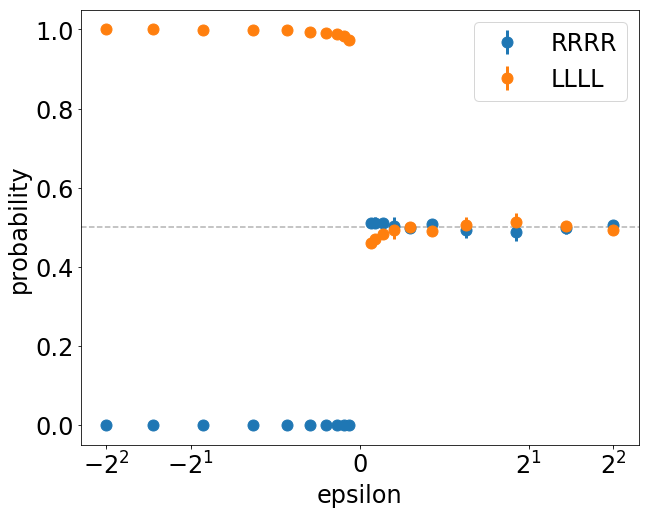

<Figure size 432x288 with 0 Axes>

In [115]:
mean_r,mean_l = zip(*means_probs)
std_r,std_l = zip(*std_probs)
traj1 = (epsilons,mean_r,std_r,'RRRR')
traj2 = (epsilons,mean_l,std_l,'LLLL')
plot_probability_of_trajctory(traj1,traj2,filename='probs_of_trajectories.png')